In [1]:
from scoresbibm.utils.data_utils import query, get_summary_df,load_model
from scoresbibm.utils.plot import plot_metric_by_num_simulations, use_style,multi_plot

from scoresbibm.tasks.unstructured_tasks import SIRTask, MultivariateNormal
from probjax.distributions.transformed_distribution import TransformedDistribution
from probjax.core import rv

import matplotlib.pyplot as plt
import seaborn as sns

import jax
import jax.numpy as jnp
import os

import logging
logging.getLogger('matplotlib.font_manager').disabled = True

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.


In [2]:
task = SIRTask(time_end=40)

observation_generator = task.get_observation_generator()
reference_sampler = task.get_reference_sampler()
observation_stream = observation_generator(jax.random.PRNGKey(8))

In [3]:
COLOR_INFECTED = "darkorange"
COLOR_RECOVERED = "seagreen"
COLOR_DEATHS = "C3"
COLOR_PARAMETER = "navy"

In [4]:
PATH = "../../results/bm_sir_new"

In [5]:
df = query(PATH, method_sde_name="vesde", method="score_transformer", num_simulations=100000)

In [6]:
model = load_model(PATH, df["model_id"].iloc[0])

In [7]:
data = task.get_data(100, rng=jax.random.PRNGKey(4))

In [8]:
theta_o = data["theta"][95]
x_o = data["x"][95][::20]
ts_dense = jnp.linspace(0,40,100)
condition_mask = jnp.array([False]*2 + [False]*100 + [True if i%20==0 else False for i in range(300)])
meta_data = jnp.concatenate([jnp.array([jnp.nan, jnp.nan]),ts_dense, ts_dense,ts_dense,ts_dense])
node_id = jnp.array([0,1] + [2]*100 + [3]*100 + [4]*100 + [5]*100)

In [9]:
all_samples = []
for i in range(6):
    sample = model.sample(500, x_o=x_o, condition_mask=condition_mask, meta_data=meta_data, rng=jax.random.PRNGKey(i))
    all_samples.append(jax.device_put(sample, jax.devices("cpu")[0]))

In [10]:
sample = jnp.concatenate(all_samples, axis=0)

In [11]:
theta12, betas, I, R,D = jnp.split(sample, [2,102, 197, 197 + 95 ], axis=-1)

betas_mean = jnp.mean(betas, axis=0)
betas_q01 = jnp.quantile(betas, 0.005, axis=0)
betas_q99 = jnp.quantile(betas, 0.995, axis=0)

I_mean = jnp.mean(I, axis=0)
I_q01 = jnp.quantile(I, 0.005, axis=0)
I_q99 = jnp.quantile(I, 0.995, axis=0)

R_mean = jnp.mean(R, axis=0)
R_q01 = jnp.quantile(R, 0.005, axis=0)
R_q99 = jnp.quantile(R, 0.995, axis=0)

D_mean = jnp.mean(D, axis=0)
D_q01 = jnp.quantile(D, 0.005, axis=0)
D_q99 = jnp.quantile(D, 0.995, axis=0)

In [12]:
import matplotlib.gridspec as gridspec
import matplotlib.colors as mcolors

cmap = mcolors.LinearSegmentedColormap.from_list('my_cmap', ['white', COLOR_PARAMETER])

/tmp/ipykernel_2934972/1873388626.py:6: UserWarning: 

`shade_lowest` has been replaced by `thresh`; setting `thresh=0.05.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(x=theta12[:,0], y=theta12[:,1], shade=True, shade_lowest=False, levels=100,cmap=cmap, ax=ax0)
/tmp/ipykernel_2934972/1873388626.py:6: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(x=theta12[:,0], y=theta12[:,1], shade=True, shade_lowest=False, levels=100,cmap=cmap, ax=ax0)


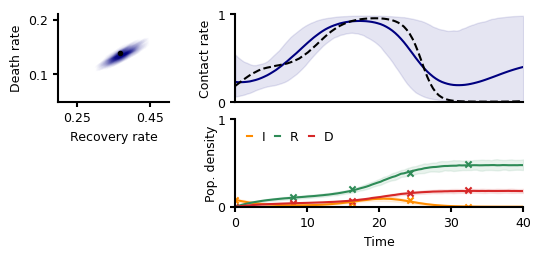

In [13]:
with use_style("pyloric"):
    fig = plt.figure(figsize=(6, 2.5))
    gs = gridspec.GridSpec(2, 3, height_ratios=[1, 1], width_ratios=[1, 1,1],wspace=0.6)
   
    ax0 = plt.subplot(gs[:1, 0])
    sns.kdeplot(x=theta12[:,0], y=theta12[:,1], shade=True, shade_lowest=False, levels=100,cmap=cmap, ax=ax0)
    plt.scatter(theta_o[0], theta_o[1], color="black", marker="o")
    ax0.set_xlabel("Recovery rate")
    ax0.set_ylabel("Death rate")
    ax0.set_xticks([0.25, 0.45])
    ax0.set_yticks([0.1, 0.2])
    ax0.set_ylim([0.05, 0.21])
    ax0.set_xlim([0.2, 0.5])
   
    ax1 = plt.subplot(gs[0, 1:])
    _ = ax1.plot(ts_dense, betas_mean, color=COLOR_PARAMETER)
    _ = ax1.fill_between(ts_dense, betas_q01, betas_q99, alpha=0.1, color=COLOR_PARAMETER)
    _ = ax1.plot(ts_dense, theta_o[2:102], color="black", linestyle="--")
    ax1.set_ylabel("Contact rate")
    ax1.set_xticks([])
    ax1.set_yticks([0,1])
    ax1.set_ylim(0,1)
    ax1.set_xlim(0, 40)  
    ax1.set_xticks([])
    
    observations_means = (I_mean, R_mean, D_mean)
    observations_q01 = (I_q01, R_q01, D_q01)
    observations_q99 = (I_q99, R_q99, D_q99)
    titles = ("I", "R", "D")
    colors = (COLOR_INFECTED, COLOR_RECOVERED, COLOR_DEATHS)
    ax = plt.subplot(gs[1,1:])
    handles =[]
    for i in range(3):
        #ax = plt.subplot(gs[1,i])
        l1 = ax.plot(ts_dense[~condition_mask[(i+1)*100+2:(i+2)*100+2]], observations_means[i], color=colors[i], label=titles[i])
        _ = ax.fill_between(ts_dense[~condition_mask[(i+1)*100+2:(i+2)*100+2]], observations_q01[i], observations_q99[i], alpha=0.1, color=colors[i])
        _ = ax.scatter(ts_dense[condition_mask[(i+1)*100+2:(i+2)*100+2]], x_o[i*len(x_o)//3:(i+1)*len(x_o)//3], marker="x", s=20, color=colors[i])
        if i == 0:
            ax.set_ylabel("Pop. density", labelpad=-0.1)
        ax.set_ylim(0, 1.)
        ax.set_xlabel("Time")
        ax.set_yticks([0, 1])
        ax.set_xlim(0, 40)
        handles.append(l1[0])
    ax.legend(handles=handles, loc="upper left", ncols=3, handlelength=0.4, columnspacing=0.8)
    
        
    fig.savefig("sir_example2_new.svg")
    plt.show()
    
    

/tmp/ipykernel_2934972/2334494380.py:6: UserWarning: 

`shade_lowest` has been replaced by `thresh`; setting `thresh=0.05.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(x=theta12[:,0], y=theta12[:,1], shade=True, shade_lowest=False, levels=50,cmap=cmap, ax=ax0)
/tmp/ipykernel_2934972/2334494380.py:6: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(x=theta12[:,0], y=theta12[:,1], shade=True, shade_lowest=False, levels=50,cmap=cmap, ax=ax0)


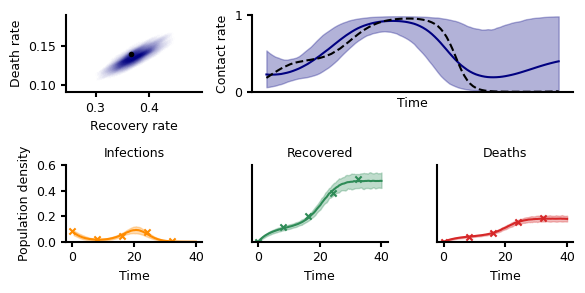

In [14]:
with use_style("pyloric"):
    fig = plt.figure(figsize=(6, 3))
    gs = gridspec.GridSpec(2, 3, height_ratios=[1, 1], width_ratios=[1, 1,1])
   
    ax0 = plt.subplot(gs[0, 0])
    sns.kdeplot(x=theta12[:,0], y=theta12[:,1], shade=True, shade_lowest=False, levels=50,cmap=cmap, ax=ax0)
    plt.scatter(theta_o[0], theta_o[1], color="black", marker="o")
    ax0.set_xlabel("Recovery rate")
    ax0.set_ylabel("Death rate")
   
    ax1 = plt.subplot(gs[0, 1:])
    _ = ax1.plot(ts_dense, betas_mean, color=COLOR_PARAMETER)
    _ = ax1.fill_between(ts_dense, betas_q01, betas_q99, alpha=0.3, color=COLOR_PARAMETER)
    _ = ax1.plot(ts_dense, theta_o[2:102], color="black", linestyle="--")
    ax1.set_ylabel("Contact rate")
    ax1.set_xticks([])
    ax1.set_yticks([0,1])
    ax1.set_ylim(0,1)
    ax1.set_xlabel("Time")
    
    observations_means = (I_mean, R_mean, D_mean)
    observations_q01 = (I_q01, R_q01, D_q01)
    observations_q99 = (I_q99, R_q99, D_q99)
    titles = ("Infections", "Recovered", "Deaths")
    colors = (COLOR_INFECTED, COLOR_RECOVERED, COLOR_DEATHS)
    for i in range(3):
        ax = plt.subplot(gs[1,i])
        _ = ax.plot(ts_dense[~condition_mask[(i+1)*100+2:(i+2)*100+2]], observations_means[i], color=colors[i])
        _ = ax.fill_between(ts_dense[~condition_mask[(i+1)*100+2:(i+2)*100+2]], observations_q01[i], observations_q99[i], alpha=0.3, color=colors[i])
        _ = ax.scatter(ts_dense[condition_mask[(i+1)*100+2:(i+2)*100+2]], x_o[i*len(x_o)//3:(i+1)*len(x_o)//3], marker="x", s=20, color=colors[i])
        ax.set_title(titles[i])
        if i == 0:
            ax.set_ylabel("Population density")
        else:
            ax.set_yticks([])
        ax.set_xlabel("Time")
        ax.set_ylim(0,0.6)
        
    fig.tight_layout()
    fig.savefig("sir_example1_new.svg")
    plt.show()
    
    

In [15]:
theta_o = data["theta"][95]
x_o = jnp.concatenate([theta_o[2:][::30], data["x"][95,-5][None]])
ts_dense = jnp.linspace(0,40,100)
condition_mask = jnp.array([False]*2 + [True if i%30==0 else False for i in range(100)] + [False if i%20==0 else False for i in range(300)])
condition_mask = condition_mask.at[-5].set(True)
meta_data = jnp.concatenate([jnp.array([jnp.nan, jnp.nan]),ts_dense, ts_dense,ts_dense,ts_dense])
node_id = jnp.array([0,1] + [2]*100 + [3]*100 + [4]*100 + [5]*100)

In [16]:
all_samples = []
for i in range(5):
    sample = model.sample(500, x_o=x_o, condition_mask=condition_mask, meta_data=meta_data, rng=jax.random.PRNGKey(i))
    all_samples.append(jax.device_put(sample, jax.devices("cpu")[0]))

In [17]:
sample = jnp.concatenate(all_samples, axis=0)

In [18]:
theta12, betas, I, R,D = jnp.split(sample, [2,102-len(x_o) + 1, 102-len(x_o)+ 1 + 100, 102-len(x_o)+ 1 + 200 ], axis=-1)

betas_mean = jnp.mean(betas, axis=0)
betas_q01 = jnp.quantile(betas, 0.005, axis=0)
betas_q99 = jnp.quantile(betas, 0.995, axis=0)

I_mean = jnp.mean(I, axis=0)
I_q01 = jnp.quantile(I, 0.005, axis=0)
I_q99 = jnp.quantile(I, 0.995, axis=0)

R_mean = jnp.mean(R, axis=0)
R_q01 = jnp.quantile(R, 0.005, axis=0)
R_q99 = jnp.quantile(R, 0.995, axis=0)

D_mean = jnp.mean(D, axis=0)
D_q01 = jnp.quantile(D, 0.005, axis=0)
D_q99 = jnp.quantile(D, 0.995, axis=0)

/tmp/ipykernel_2934972/1673267171.py:8: UserWarning: 

`shade_lowest` has been replaced by `thresh`; setting `thresh=0.05.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(x=theta12[:,0], y=theta12[:,1], shade=True, shade_lowest=False, levels=100,gridsize=200,cmap=cmap, ax=ax0)
/tmp/ipykernel_2934972/1673267171.py:8: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(x=theta12[:,0], y=theta12[:,1], shade=True, shade_lowest=False, levels=100,gridsize=200,cmap=cmap, ax=ax0)


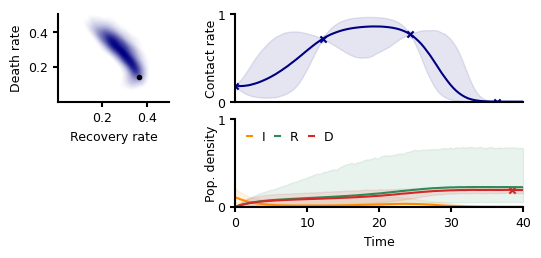

In [20]:
# OLD Figure

with use_style("pyloric"):
    fig = plt.figure(figsize=(6, 2.5))
    gs = gridspec.GridSpec(2, 3, height_ratios=[1, 1], width_ratios=[1, 1,1],wspace=0.6)
   
    ax0 = plt.subplot(gs[:1, 0])
    sns.kdeplot(x=theta12[:,0], y=theta12[:,1], shade=True, shade_lowest=False, levels=100,gridsize=200,cmap=cmap, ax=ax0)
    plt.scatter(theta_o[0], theta_o[1], color="black", marker="o")
    ax0.set_xlabel("Recovery rate")
    ax0.set_ylabel("Death rate")
    ax0.set_xticks([0.2, 0.4])
    ax0.set_yticks([0.2, 0.4])
    ax0.set_ylim([0.0, 0.5])
    ax0.set_xlim([0.0, 0.5])
   
    ax1 = plt.subplot(gs[0, 1:])
    _ = ax1.plot(ts_dense[~condition_mask[2:102]], betas_mean, color=COLOR_PARAMETER)
    _ = ax1.fill_between(ts_dense[~condition_mask[2:102]], betas_q01, betas_q99, alpha=0.1, color=COLOR_PARAMETER)
    _ = ax1.scatter(ts_dense[condition_mask[2:102]], x_o[:4],marker="x", color=COLOR_PARAMETER, s=20)
    #_ = ax1.plot(ts_dense, theta_o[2:102], color="black", linestyle="--")
    ax1.set_ylabel("Contact rate", labelpad=-0.1)
    ax1.set_xticks([])
    ax1.set_xlim(0,40)
    ax1.set_yticks([0,1])
    ax1.set_ylim(0,1)
    
    observations_means = (I_mean, R_mean, D_mean)
    observations_q01 = (I_q01, R_q01, D_q01)
    observations_q99 = (I_q99, R_q99, D_q99)
    titles = ("I", "R", "D")
    colors = (COLOR_INFECTED, COLOR_RECOVERED, COLOR_DEATHS)
    ax = plt.subplot(gs[1,1:])
    handles = []
    for i in range(3):
        
        l1 = ax.plot(ts_dense[~condition_mask[(i+1)*100+2:(i+2)*100+2]], observations_means[i], color=colors[i], label=titles[i])
        _ = ax.fill_between(ts_dense[~condition_mask[(i+1)*100+2:(i+2)*100+2]], observations_q01[i], observations_q99[i], alpha=0.1, color=colors[i])
        
        if i == 0:
            ax.set_ylabel("Pop. density", labelpad=-0.1)
        ax.set_ylim(0, 1.)
        ax.set_xlabel("Time")
        ax.set_yticks([0, 1])
        ax.set_xlim(0,40)
        handles.append(l1[0])
    ax.legend(handles=handles, loc="upper left", ncols=3, handlelength=0.4, columnspacing=0.8)
    _ = ax.scatter(ts_dense[-5], x_o[-1], marker="x", s=20, color=colors[-1])
    #fig.tight_layout()
    fig.savefig("sir_example_emulation2_new.svg")
    plt.show()
    